In [1]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import numpy as np
import time
import gc
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# don't import tensorflow as is since we will have tf 2.0 and this will break things
#import tensorflow as tf
# do this instead to maintain compatibility with tf 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, TensorDataset


from processors import MnliProcessor, ImdbProcessor
from firebert_fve import FireBERT_FVE
from firebert_fse import FireBERT_FSE



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("running on GPU")
else:
    device = "cpu"
    print("running on CPU")

running on CPU


In [3]:
task = "co-tuned_MNLI_on_lightning_final_filter"
#task = "MNLI"

# create a FIVE classifier

# load the right processor class
if "MNLI" in task:
    processor = MnliProcessor({'sample_percent':-1})
elif task == "IMDB":
    processor = ImdbProcessor({'sample_percent':-1})
    
labels = processor.get_labels()

# prepare hyperparameters
hparams = {'batch_size': 64}

# now instantiate the model
fve = FireBERT_FVE(load_from="resources/models/"+task+"/pytorch_model.bin", 
                    processor=processor, 
                    hparams=hparams)
if device != "cpu":
    fve.cuda(device)
fve.eval();

# create a FuSE classifier for MNNLI

fse = FireBERT_FSE(load_from="resources/models/"+task+"/pytorch_model.bin", 
                    processor=processor, 
                    hparams=hparams)
if device != "cpu":
    fse.cuda(device)
fse.eval();   

INFO:absl:Using scratch/tf_cache to cache modules.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
def eval_example(model, example, count=None, std=None):
    # this creates a perturbation field. it will be in cpu() space
    big_batch, attention_mask, token_type_ids, points, important_words, words = model.perturb_example(example, std=std, count=count)
    #print(points.shape)
    
    # break this up into batches so the BERT can handle it
    batch_size = model.hparams.batch_size
    #print(big_batch.shape[0],count, batch_size)
    logits= []
    
    with torch.no_grad():
        for i in range(0,big_batch.shape[0],batch_size):
            size = min(batch_size, big_batch.shape[0]-i)
            
            mini_batch_embeds = big_batch.narrow(0,i,size).to(device)
            mini_batch_mask = attention_mask.narrow(0,i,size).to(device)
            mini_batch_types = token_type_ids.narrow(0,i,size).to(device)

            mini_batch_logits = model(inputs_embeds=mini_batch_embeds,
                                         attention_mask=mini_batch_mask,
                                         token_type_ids=mini_batch_types,
                                         extend=False)

            logits.append(mini_batch_logits.cpu())
            #print(i, mini_batch_logits.shape)

        logits = torch.cat(logits, dim=0)
        
    # print(logits.shape)
    # print("ee: words:",len(words))
    return points, logits, important_words, words


In [5]:
def eval_single(model, text_a, text_b, label):
    # make "feature" tensors out of those
    example, input_ids, attention_mask, token_type_ids, label = \
        processor.make_single_example_with_features(text_a, text_b, label, device=model.device)
    with torch.no_grad():
        embeddings = model.bert.get_input_embeddings()(input_ids).detach()
        logits = model(inputs_embeds=embeddings, attention_mask=attention_mask, token_type_ids=token_type_ids, extend=False)
        cls = torch.argmax(logits, dim=1)
    return example, cls, logits

In [6]:
def combined_classification(model, example, count=None, std=None):
    points, logits, important_words, words = eval_example(model, example, count=count, std=std)
    #print("batch logits:", logits)
    classes = torch.argmax(logits, dim=1)
    combined_logits = logits.mean(dim=0)
    combined_class = torch.argmax(combined_logits).item()
    
    counts = [0] * len(labels)
    raw_counts = np.unique(classes.cpu().numpy(), return_counts=True)
    # print(raw_counts)
    for i in range(len(raw_counts[0])):
        counts[raw_counts[0][i]] = raw_counts[1][i]
    # print("counts:", counts)

    vote = torch.argmax(torch.tensor(counts, device="cpu")).item()
    # print("vote:", vote)
    
    return points, vote, combined_class, combined_logits, classes, counts, important_words, words

In [50]:
def plot(kind, points, classes, labels, counts, center_word, center_class): 
    if points.shape[1] > 2:
        points = points[:,:]
    #data_classes = classes.unique()
    palette = ['red','green','blue', 'orange', 'lightgreen', 'lightblue']
    #palette_small = palette[:data_classes.shape[0]]
    #sns.set_palette(palette)
    palette_dict = {}
    for i,c in enumerate(palette):
        palette_dict.update({i:c})
    
    # Create dummy Line2D objects for legend
    hs = [plt.Line2D([0], [0], marker='o', markersize=1, color=p, linestyle='None') for p in palette]


    tsne_df = pd.DataFrame({'X':points[:,0],
                        'Y':points[:,1],
                        'classes':classes})
    fig = plt.figure(figsize=(12, 12))
    g = sns.scatterplot(x="X", y="Y",
                    hue="classes",
                    palette=palette_dict,
                    legend='full',
                    alpha=0.5,
                    s=50,
                    data=tsne_df);

    # Plot legend.
    legend_texts = [labels[i%len(labels)]+(" (adversarial and neighbors)" if i >= len(labels) \
                                           else " (original and neighbors)")+
                    ': '+str(counts[i]) for i in range(2*len(labels))]
    plt.legend(hs, legend_texts, loc="upper right", markerscale=10, scatterpoints=1, fontsize=14)
    
    plt.axis('off')

    plt.title("Classifications of perturbations of the word vectors for original '"+
              center_word[0][0]+ "' and adversarial '" +center_word[1][0]+ 
              "'\nwithin their respective samples ("+kind+")", fontsize=18)
    


In [51]:
def plot_fields(model, text_a, text_b, label=None, adv_text_b=None, adv_label=None, 
                count=100, std=0.1, tsne=False, weight=0):
    print("text_a:", text_a)
    print()
    print("text_b:", text_b)
    if label is not None:
        print("supposed label:", label)
    else:
        label=labels[0]

        # evaluate the original, make example structure
    example, cls, logits = eval_single(model, text_a, text_b, label)

    # evaluate the field around it
    points, vote, combined_class, combined_logits, classes, counts, important_words, _ = \
        combined_classification(model, example, count=count, std=std)
    important_words = [important_words[:1]]
    
    print("critical words:", important_words[0])
    print("single label:", labels[cls.item()], ", single logits:", logits.cpu().tolist()[0])
    print("vote:", labels[vote], "vote counts:", counts)
    print("vote for avg. logits:", labels[combined_class], "avg. logits:", combined_logits.tolist())
    print()
    
    # convert classes into float, add as column to tensor
    float_classes = classes.float().unsqueeze(1).repeat(1,1)
    points_combined = torch.cat((points, float_classes), dim=1)

    if adv_text_b is not None:
        print("adversarial text_b:", adv_text_b)
        if adv_label is not None:
            print("supposed (adversarial) label:", adv_label)
        else:
            adv_label=labels[0]
        # evaluate the original, make example structure
        adv_example, adv_cls, adv_logits = eval_single(model, text_a, adv_text_b, adv_label)

        # evaluate the field around it
        adv_points, adv_vote, adv_combined_class, adv_combined_logits, adv_classes, adv_counts, imp_adv_words, _ = \
            combined_classification(model, adv_example, count=count, std=std)
        
        imp_adv_words = [imp_adv_words[:1]]
        print("critical words:", imp_adv_words[0])
        print("single label:", labels[adv_cls.item()], ", single logits:", adv_logits.cpu().tolist()[0])
        print("vote:",labels[adv_vote], ", vote counts:", counts)
        print("vote for avg. logits:", labels[adv_combined_class], ", avg. logits:", adv_combined_logits.tolist())
        print()

        points = torch.cat((points, adv_points),0)
        color_classes = torch.cat((classes, adv_classes+3),0)
        classes = torch.cat((classes, adv_classes),0)
        
        #counts = [count+adv_count for count, adv_count in zip(counts,adv_counts)]
        counts = counts+adv_counts
        important_words += imp_adv_words
    
    # attach the classes to the set of points so that t-SNE or PCA can do better work
    points = torch.cat((points, classes.float().unsqueeze(1)*weight), dim=1)
    
    if tsne:
        #plot t-SNE
        tp = TSNE(n_components=2).fit_transform(points)
        plot("t-SNE, std="+str(std), tp, color_classes, labels, counts, important_words, cls.item());
    else:
        #plot PC
        pp = PCA(n_components=2).fit_transform(points)
        plot("PCA, std="+str(std)+"", pp, color_classes, labels, counts, important_words, cls.item());


    

text_a: so i have to find a way to supplement that

text_b: I need a way to add something extra.
supposed label: entailment
critical words: ['extra']
single label: entailment , single logits: [-2.412569761276245, 2.869556427001953, 0.24252662062644958]
vote: entailment vote counts: [0, 7598, 2402]
vote for avg. logits: entailment avg. logits: [-2.0263614654541016, 1.7491506338119507, 0.658890962600708]

adversarial text_b: I need a way to add something additive.
supposed (adversarial) label: contradiction
critical words: ['additive']
single label: entailment , single logits: [-2.3923304080963135, 2.6889610290527344, 0.35805803537368774]
vote: entailment , vote counts: [0, 7598, 2402]
vote for avg. logits: entailment , avg. logits: [-2.470266103744507, 2.0859432220458984, 0.9197784066200256]



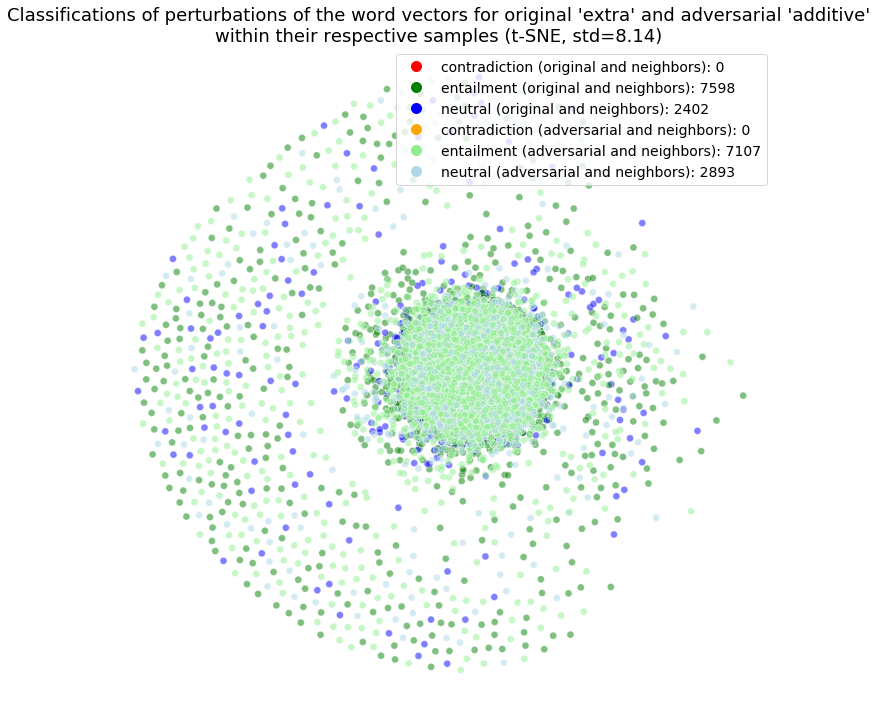

In [55]:
plot_FVE = True
if plot_FVE:
    count = 10000
    tsne = True
    weight=0

#     premise = "pedestrian walking on the street"
#     hypothesis = "A person walking inside a building ."
#     paper_label = "contradiction"
#     # And here is the TextFooler adversarial sample:
#     adv_hypothesis = "A person walking within a buildings ."
#     paper_adv_label = "entailment" 

#     premise = "pedestrian walking on the street"
#     hypothesis = "A person walking inside a building ."
#     paper_label = "contradiction"
#     # And here is the TextFooler adversarial sample:
#     adv_hypothesis = "A person walking within a buildings ."
#     paper_adv_label = "entailment" 

    
    if "MNLI" in task:
#         premise = "pedestrian walking on the street"
#         hypothesis = "A person walking inside a building ."
#         paper_label = "contradiction"
#         # And here is the TextFooler adversarial sample:
#         adv_hypothesis = "A person walking within a buildings ."
#         paper_adv_label = "entailment"

        premise = 'so i have to find a way to supplement that'
        hypothesis = "I need a way to add something extra."
        paper_label = "entailment"
        # And here is the TextFooler adversarial sample:
        adv_hypothesis = "I need a way to add something additive."
        paper_adv_label = "contradiction"
        


    for std in [8.14]: #0.13, 0.1,0.2,0.5,1.0,2.0,5.0]:
        plot_fields(fve, premise, hypothesis, label=paper_label, adv_text_b=adv_hypothesis, adv_label=paper_adv_label, 
                    tsne=tsne, count=count, std=std, weight=weight)
        plt.show()




# # Another:
# premise = "A man in a bright yellow shirt juggles while riding a unicycle ."
# hypothesis = "Man performs a juggling act on a unicycle ."
# paper_label = "entailment"
# # And here is the TextFooler adversarial sample:
# adv_hypothesis = "Man performs a juggling act on a rollerblades ."
# paper_adv_label = "contradiction" 

# plot_fields(premise, hypothesis, label=paper_label, adv_text_b=adv_hypothesis, adv_label=paper_adv_label, 
#             count=count, std=std)
# plt.show()

# # Another:
# premise = "A little girl on a piece of playground equipment"
# hypothesis = "A kid is doing a thing ."
# paper_label = "entailment"
# adv_hypothesis = "A boy is doing a thing ."
# paper_adv_label = "neutral"

# plot_fields(premise, hypothesis, label=paper_label, adv_text_b=adv_hypothesis, adv_label=paper_adv_label, 
#             count=count, std=std)
# plt.show()



In [49]:
font = 16
#
# small helper function courtesy of Scott Boston/stackoverflow
#
def label_points(x, y, val, col, ax, palette):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_offset = 2 * (xlim[1]-xlim[0]) / 100
    y_offset = -0.5 * (ylim[1]-ylim[0]) / 100

    a = pd.concat({'x': x, 'y': y, 'val': val, 'col':col}, axis=1)
    for i, point in a.iterrows():
        if i == 0: #original sample
            ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                    bbox=dict(facecolor=palette[point['col']], alpha=0.5), fontsize=font)
        elif i == len(x)/2: # adversarial sample
            ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']),
                    bbox=dict(facecolor=palette[point['col']], alpha=0.5), fontsize=font)
        else:
            ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']), fontsize=font)

#
#plotting words with labels
#
def plot_words(kind, points, classes, labels, counts, center_words, words): 
    if points.shape[1] > 2:
        points = points[:,:]
        
    # adjust vectors until all are 5% apart, vertically.
    work_done = True
    adjust = 0.01
    size_y = max(points[1]) - min(points[1])
    while work_done:
        work_done = False
        for i, point1 in enumerate(points):
            for j, point2 in enumerate(points):
                if i != j and abs(point1[1]-point2[1]) < font/200 * size_y:
                    choice = random.randrange(2)*2-1
                    point1[1] += choice*adjust* size_y
                    point2[1] -= choice*adjust* size_y
                    #print("adjusting", i, j)
                    work_done = True
#         adjust *= 0.99
#         if adjust < 0.00001:
#             print("time's up")
#             break
    
    #data_classes = classes.unique()
    palette = ['red','green','blue', 'orange', 'lightgreen', 'lightblue']
    #palette_small = palette[:data_classes.shape[0]]
    #sns.set_palette(palette)
    palette_dict = {}
    for i,c in enumerate(palette):
        palette_dict.update({i:c})
    
    # Create dummy Line2D objects for legend
    hs = [plt.Line2D([0], [0], marker='o', markersize=1, color=p, linestyle='None') for p in palette]

#     print(points.shape)
#     print(classes.shape)
#     print(len(words), words)
    df = pd.DataFrame({'PCA0':points[:,0],
                        'PCA1':points[:,1],
                        'classes':classes,
                        'words':words})
    display (df)
    fig = plt.figure(figsize=(12, 12))
    axis = sns.scatterplot(x="PCA0", y="PCA1",
                    hue="classes",
                    palette=palette_dict,
                    legend='full',
                    alpha=1,
                    s=200,
                    data=df);
    label_points(df.PCA0, df.PCA1, df.words, df.classes, axis, palette)  
    axis.axes.get_xaxis().get_label().set_visible(False)
    axis.axes.get_yaxis().get_label().set_visible(False)
    plt.axis('off')

    # Plot legend.
    legend_texts = [labels[i%len(labels)]+(" (adversarial and neighbors)" if i >= len(labels) \
                                           else " (original and neighbors)")+\
                                            ': '+str(counts[i]) for i in range(2*len(labels))]
    plt.legend(hs, legend_texts, loc="upper right", markerscale=2, scatterpoints=1, fontsize=14)
    
    plt.title("Classifications for original '"+
              center_words[0][0]+"' and adversarial '"+ center_words[1][0]+"'" +
              " \nand their respective nearest neighbors", fontsize=18)
    

In [15]:
def plot_around_word(model, text_a, text_b, label=None, adv_text_b=None, adv_label=None, count=100, tsne=False, weight=0):
    print("text_a:", text_a)
    print()
    print("text_b:", text_b)
    if label is not None:
        print("supposed label:", label)
    else:
        label=labels[0]

        # evaluate the original, make example structure
    example, cls, logits = eval_single(model, text_a, text_b, label)

    # evaluate the field around it
    points, vote, combined_class, combined_logits, classes, counts, important_words, words = \
        combined_classification(model, example, count=count)
    important_words = [important_words[:1]]
    color_classes = classes
    
    print("critical words:", important_words)
    print("single label:", labels[cls.item()], ", single logits:", logits.cpu().tolist()[0])
    print("vote:", labels[vote], "vote counts:", counts)
    print("vote for avg. logits:", labels[combined_class], "avg. logits:", combined_logits.tolist())
    print()
    
    # convert classes into float, add as column to tensor
    print(classes.size())
    print(points.size())
    float_classes = classes.float().unsqueeze(1).repeat(1,1)
    points_combined = torch.cat((points, float_classes), dim=1)

    if adv_text_b is not None:
        print("adversarial text_b:", adv_text_b)
        if adv_label is not None:
            print("supposed (adversarial) label:", adv_label)
        else:
            adv_label=labels[0]
        # evaluate the original, make example structure
        adv_example, adv_cls, adv_logits = eval_single(model, text_a, adv_text_b, adv_label)

        # evaluate the field around it
        adv_points, adv_vote, adv_combined_class, adv_combined_logits, adv_classes, adv_counts, imp_adv_words, adv_words = \
            combined_classification(model, adv_example, count=count)
        
        imp_adv_words = [imp_adv_words[:1]]
        print("critical words:", adv_words)
        print("single label:", labels[adv_cls.item()], ", single logits:", adv_logits.cpu().tolist()[0])
        print("vote:",labels[adv_vote], ", vote counts:", counts)
        print("vote for avg. logits:", labels[adv_combined_class], ", avg. logits:", adv_combined_logits.tolist())
        print()

        points = torch.cat((points, adv_points),0)
        color_classes = torch.cat((classes, adv_classes+3),0)
        classes = torch.cat((classes, adv_classes),0)
        
        #counts = [count+adv_count for count, adv_count in zip(counts,adv_counts)]
        counts = counts+adv_counts
        important_words += imp_adv_words
        words += adv_words
    
    # attach the classes to the set of points so that t-SNE or PCA can do better work
    points = torch.cat((points, classes.float().unsqueeze(1)*weight), dim=1)
    

    if tsne:
        from sklearn.manifold import TSNE
        from sklearn.metrics import pairwise_distances

        distance_matrix = pairwise_distances(points, points, metric='cosine', n_jobs=-1)
        t_model = TSNE(metric="precomputed", n_components=2)
        
        tp= t_model.fit_transform(distance_matrix)
        plot_words("t-SNE", tp, color_classes, labels, counts, important_words, words);
    else:
        #plot PC
        pp = PCA(n_components=2).fit_transform(points)
        plot_words("PCA", pp, color_classes, labels, counts, important_words, words);


    

In [ ]:
plot_FSE = False
if plot_FSE:
    count = 12
    tsne = False
    weight=0

    if "MNLI" in task:
#         premise = "pedestrian walking on the street"
#         hypothesis = "A person walking inside a building ."
#         paper_label = "contradiction"
#         # And here is the TextFooler adversarial sample:
#         adv_hypothesis = "A person walking within a buildings ."
#         paper_adv_label = "entailment"
        
        premise = 'so i have to find a way to supplement that'
        hypothesis = "I need a way to add something extra."
        paper_label = "entailment"
        # And here is the TextFooler adversarial sample:
        adv_hypothesis = "I need a way to add something additive."
        paper_adv_label = "contradiction"
        

    elif task == "IMDB":
        premise = ""
        hypothesis = "The characters, cast in impossibly contrived situations, are totally estranged from reality."
        paper_label = "contradiction"
        # And here is the TextFooler adversarial sample:
        adv_hypothesis = "The characters, cast in impossibly engineered circumstances, are fully estranged from reality."
        paper_adv_label = "entailment" 


    plot_around_word(fse, premise, hypothesis, label=paper_label, adv_text_b=adv_hypothesis, adv_label=paper_adv_label, 
                tsne=tsne, count=count, weight=weight)
    plt.show()



In [ ]:
# points = torch.tensor([[x,x] for x in range(6)])
# classes = torch.tensor([x for x in range(6)])
# labels = ["contradiction", "entailment", "neutral"]
# counts =  [-x for x in range(6)]

# plot("PCA", points, classes, labels, counts,"",0)